In [1]:
# Imports
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Maps numeric actions to semantic actions
action_map = {
    1: "UP",
    2: "DOWN",
    3: "LEFT",
    4: "RIGHT"
}

In [3]:
# Input q-function --> Output value function
# Used for plotting value grids with imshow
def plot_valuemap(q):
    v = {}
    for row in range(7):
        for col in range(10):
            v[tuple((row,col))] = max([
                q[tuple((row,col,1))],
                q[tuple((row,col,2))], 
                q[tuple((row,col,3))], 
                q[tuple((row,col,4))], 
            ])
    plt.imshow(np.array([*v.values()]).reshape(7,10))
    plt.colorbar()
    plt.show()

In [10]:
# GridWorld Class
class GridWorld:
    
    # Constructor
    def __init__(self):
        # Rewards
        self.world = np.array([
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ])
        # Wind
        self.wind = np.array([
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
        ])

    # Input x, y, and numeric action --> Output new unclipped x, y
    def step(self, x, y, action):
        wind = self.wind[x][y]
        if action == 1:
            return x-1, y
        elif action == 2:
            return x+1, y
        elif action == 3:
            return x, y-1
        elif action == 4:
            return x, y+1
        
    # Input x, y --> Output reward
    def reward(self, x, y):
        if x not in range(0,7) or y not in range(0,10):
            return -1
        else:
            return self.world[x][y]
        
    # Input x, y --> Output True if position is terminal state else False
    def terminated(self, x, y):
        return True if (x==3 and y==7) else False
    
    # Input policy --> Output episode in format [(state, action reward)...n]
    def episode(self, policy, x=3, y=0, max_steps=1000, epsilon=0.1):
        episode = []
        for step in range(max_steps):
            if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
                action = random.choice(list(action_map.keys()))
            else:
                action = policy[tuple([x, y])]
            x_new, y_new = self.step(x, y, action)
            reward = self.reward(x_new, y_new)
            x_new = np.clip(x_new, 0, 6)
            y_new = np.clip(y_new, 0, 9)
            episode.append(tuple([tuple([x, y]), action, reward]))
            if self.terminated(x_new, y_new):
                break
            else:
                x=x_new
                y=y_new
        return episode

In [11]:
# Agent class
class Agent:
    
    # Constructor
    def __init__(self):
        self.gridworld = GridWorld()
        self.x = 3
        self.y = 0
        self.x_prev = None
        self.y_prev = None
        self.gamma = 0.9
        self.epsilon = 0.1
        self.q = {tuple([row, col, action]): np.random.normal(0, 1) for row in range(self.gridworld.world.shape[0]) for col in range(self.gridworld.world.shape[1]) for action in action_map.keys()}
        self.p = {tuple([row, col]): max(action_map.keys(), key = lambda a: self.q[tuple([row, col, a])]) for row in range(self.gridworld.world.shape[0]) for col in range(self.gridworld.world.shape[1])}
        self.r = {tuple([row, col, action]): [] for row in range(self.gridworld.world.shape[0]) for col in range(self.gridworld.world.shape[1]) for action in action_map.keys()}
    
    # Wrapper function for GridWorld.step()
    def step(self, action):
        self.x_prev = self.x
        self.y_prev = self.y
        self.x, self.y = self.gridworld.step(self.x, self.y, action)
        reward = self.gridworld.reward(self.x, self.y)
        self.x = np.clip(self.x, 0, 6)
        self.y = np.clip(self.y, 0, 9)
        return reward
    
    def reset(self):
        self.x = 3
        self.y = 0
    
    # Wrapper function for GridWorld.episode()
    def episode(self):
        return self.gridworld.episode(self.p)
    
    # Wrapper function for GridWorld.reward()
    def reward(self):
        return self.gridworld.reward(self.x, self.y)
    
    # Wrapper function for GridWorld.terminated()
    def terminated(self):
        return self.gridworld.terminated(self.x, self.y)
    
    # Monte Carlo control on-policy policy evaluation (for e-soft policies)
    def mc_onpolicy(self, iterations):
        for iteration in tqdm(range(iterations)):
            episode = self.episode()
            G = 0
            for T, step in enumerate(reversed(episode)):
                state, action, reward = step
                G = agent.gamma * G + reward
                if not any([(state, action) == row for row in [(x[0], x[1]) for x in episode[:-T-1]]]):
                    sa = tuple([state[0], state[1], action])
                    self.r[sa].append(G)
                    self.q[sa] = np.mean(self.r[sa])
                    self.p[state] = max(action_map.keys(), key = lambda a: self.q[tuple([state[0], state[1], a])])
                    
    # SARSA on-policy (TD control)
    def SARSA(self, iterations):
        alpha = 0.5
        epsilon = 0.1
        max_steps = 1000
        self.q[tuple([3,7,1])] = 0
        self.q[tuple([3,7,2])] = 0
        self.q[tuple([3,7,3])] = 0
        self.q[tuple([3,7,4])] = 0
        for iteration in tqdm(range(iterations)):
            self.reset()
            for step in range(max_steps):
                if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
                    A1 = random.choice(list(action_map.keys()))
                else:
                    A1 = max(action_map.keys(), key = lambda a: self.q[tuple([self.x, self.y, a])])
                reward = self.step(A1)
                if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
                    A2 = random.choice(list(action_map.keys()))
                else:
                    A2 = max(action_map.keys(), key = lambda a: self.q[tuple([self.x, self.y, a])])
                sa1 = tuple([self.x_prev, self.y_prev, A1])
                sa2 = tuple([self.x, self.y, A2])
                agent.q[sa1] = agent.q[sa1] + alpha * ( reward + self.gamma * agent.q[sa2] - agent.q[sa1])
                if self.terminated():
                    break
                    
    def qLearning(self, iterations):
        pass
    
    def expSARSA(self, iterations):
        pass
    
    def nstepSARSA(self, iterations):
        pass

100%|██████████| 10000/10000 [00:10<00:00, 917.31it/s]


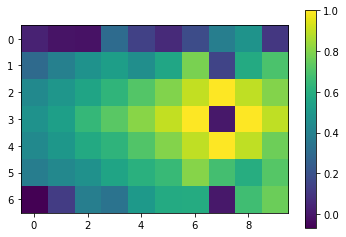

In [13]:
agent = Agent()

agent.SARSA(10000)

plot_valuemap(agent.q)